In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
session = tf.InteractiveSession()

from exoplanet import transit

In [35]:
T = tf.float64

c1 = tf.constant(0.5, dtype=T)
c2 = tf.constant(0.5, dtype=T)
ld = transit.QuadraticLimbDarkening(c1, c2)

N = 1000
r_ref = tf.constant(0.1 + np.zeros(N), dtype=T)
z_ref = (1 + r_ref) * tf.constant(np.linspace(0.0, 1.0, N), dtype=T)

r_var = tf.placeholder(T, (None, None))
z_var = tf.placeholder(T, (None, None))
delta_var = transit.transit_depth(ld, z_var, r_var, n_integrate=1000)

delta_exact = transit.transit_depth(ld, z_var, r_var, n_integrate=500000)
ns = 2**np.arange(1, 14)
deltas = []
for n in ns:
    deltas.append(tf.abs(delta_exact - transit.transit_depth(ld, z_var, r_var, n_integrate=n)))
delta_z = transit.transit_depth(ld, z_ref, r_ref, n_integrate=1000) - transit.transit_depth(ld, z_ref, r_ref, n_integrate=500000)

In [36]:
z_val = z.eval()
rors = np.array([0.01, 0.04, 0.16, 0.64])
shape = np.zeros((len(rors), len(z_val)))
fd = {r_var: rors[:, None] + shape, z_var: z_val[None, :] + shape}

ld_cs = [(0.5, 0.5), (0.1, 0.8), (0.8, 0.1)]

err = np.empty((len(ld_cs), len(ns), len(rors), len(z_val)))
for i, c in enumerate(ld_cs):
    fd[c1] = c[0]
    fd[c2] = c[1]
    err[i] = session.run(deltas, feed_dict=fd)

# fd = {r_var: rors[:, None] + shape, z_var: z_val[None, :] + shape}
# session.run([deltas, delta_z], feed_dict=fd)

In [37]:
err.shape

(3, 13, 4, 1000)

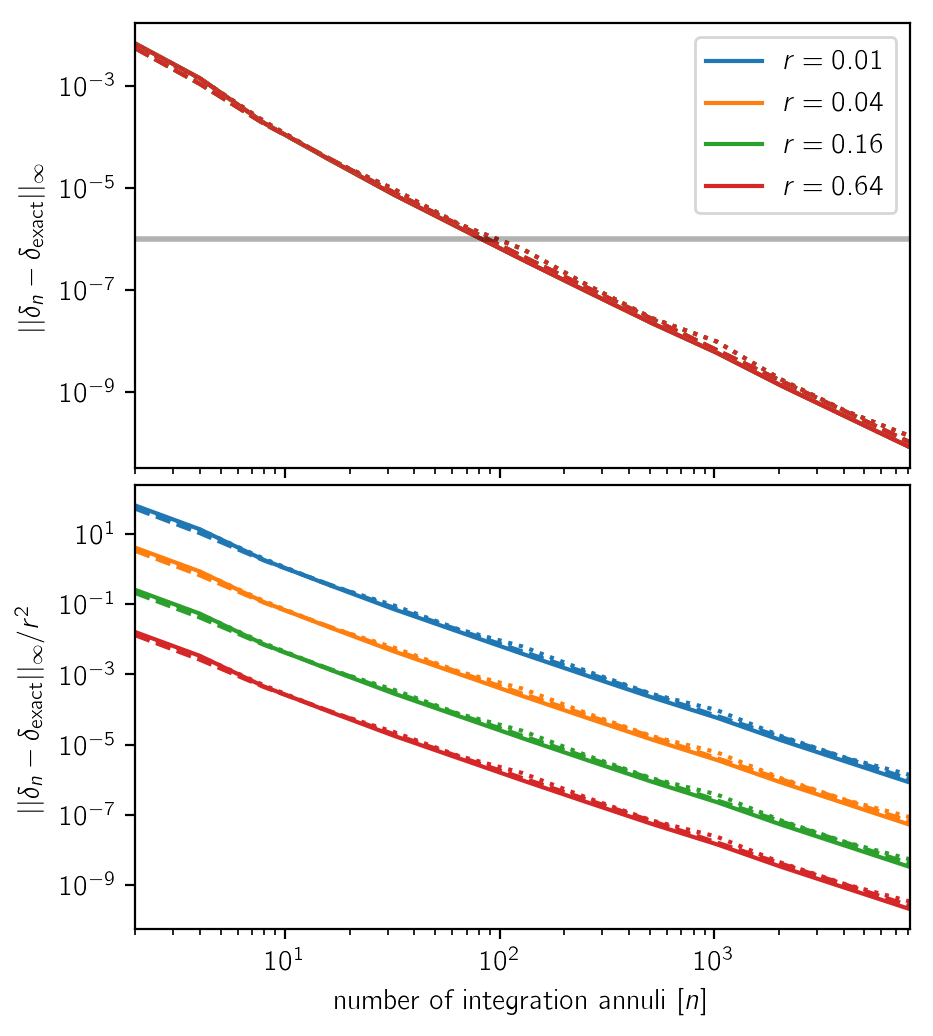

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

for i, (c, s) in enumerate(zip(ld_cs, ["solid", "dashed", "dotted"])):
    for j, ror in enumerate(rors):
        color = "C{0}".format(j)
        label = "$r = {0:.2f}$".format(ror) if s == "solid" else None

        ax = axes[0]
        ax.loglog(ns, err_val[i, j], color=color, linestyle=s, label=label)
        
        ax = axes[1]
        ax.loglog(ns, err_val[i, j] / ror**2, color=color, linestyle=s, label=label)

axes[0].axhline(1e-6, color="k", lw=2.0, alpha=0.3)
        
axes[0].set_ylabel("$||\delta_n - \delta_\mathrm{exact}||_\infty$")
axes[1].set_ylabel("$||\delta_n - \delta_\mathrm{exact}||_\infty / r^2$")
axes[1].set_xlabel("number of integration annuli $[n]$")
axes[1].set_xlim(ns.min(), ns.max())
axes[0].legend()

fig.subplots_adjust(hspace=0.04)

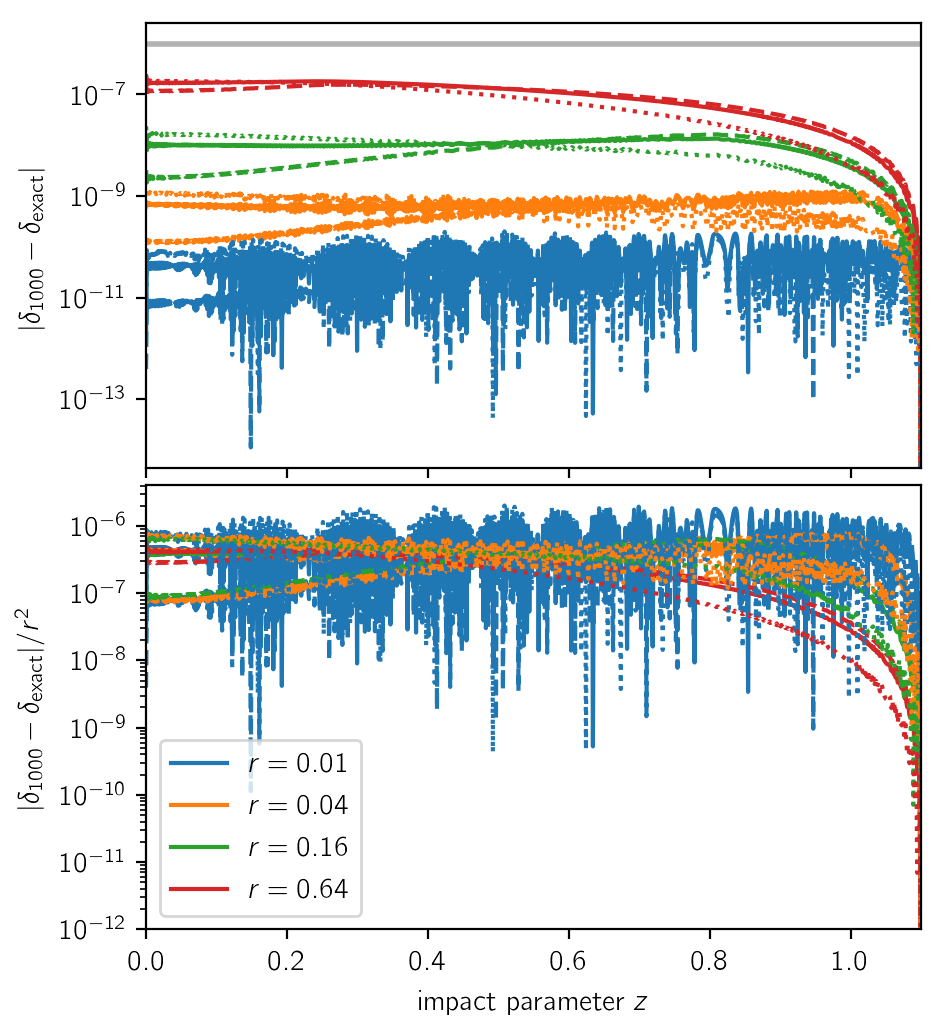

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

for i, (c, s) in enumerate(zip(ld_cs, ["solid", "dashed", "dotted"])):
    for j, ror in enumerate(rors):
        color = "C{0}".format(j)
        label = "$r = {0:.2f}$".format(ror) if s == "solid" else None

        ax = axes[0]
        ax.semilogy(z_val, np.abs(err_z[i, j]), color=color, linestyle=s, label=label)
        
        ax = axes[1]
        ax.semilogy(z_val, np.abs(err_z[i, j] / ror**2), color=color, linestyle=s, label=label)

axes[0].axhline(1e-6, color="k", lw=2.0, alpha=0.3)

axes[0].set_ylabel("$|\delta_\mathrm{1000} - \delta_\mathrm{exact}|$")
axes[1].set_ylabel("$|\delta_\mathrm{1000} - \delta_\mathrm{exact}| / r^2$")
axes[1].set_xlabel("impact parameter $z$")
axes[1].set_xlim(z_val.min(), z_val.max())
axes[1].legend()

fig.subplots_adjust(hspace=0.04)

In [50]:
ror = r.eval()
nums = 2**np.arange(10, 22)
times = []
for n in nums[::-1]:
    z_var = tf.constant(np.linspace(0.0, 1.0 + ror, n), dtype=T)
    delta_var = transit.transit_depth(ld, z_var, r, n_integrate=1000)
    
    session.run(delta_var, feed_dict=fd)
    res = %timeit -o session.run(delta_var, feed_dict=fd)
    times.append(res.best)
    break

1 loop, best of 3: 17 s per loop


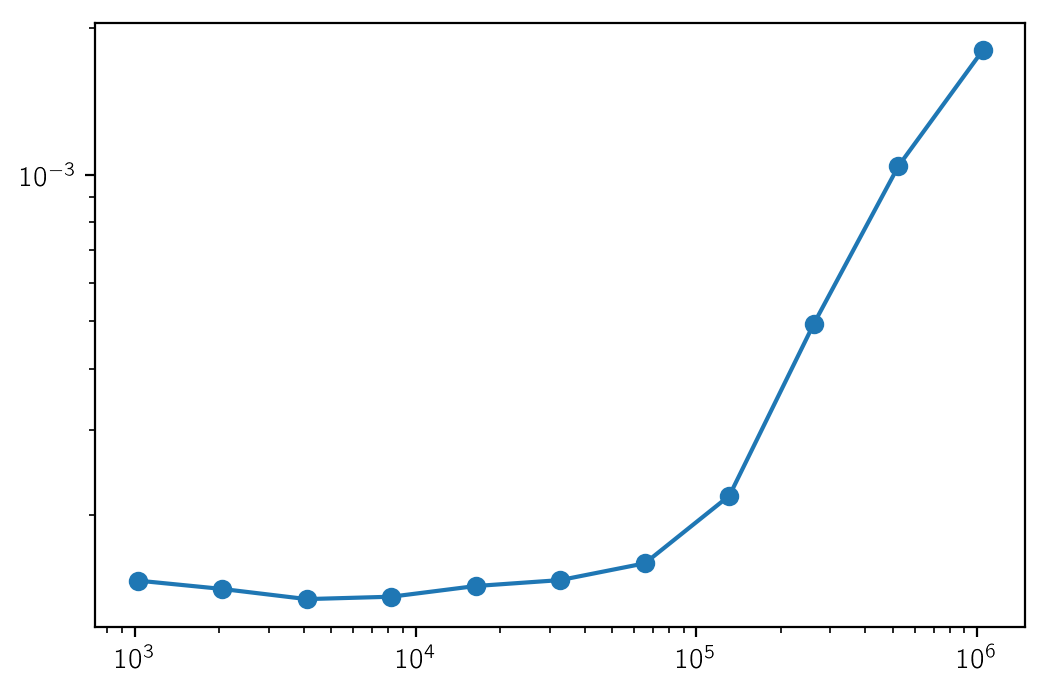

In [49]:
plt.loglog(nums[:-1], times[:-1], "o-")

In [48]:
nums

array([   1024,    2048,    4096,    8192,   16384,   32768,   65536,
        131072,  262144,  524288, 1048576, 2097152])